# Advanced Encoding: Using Model-Derived Representations of Naturalistic Stimuli to Encode Brain Data

The predictors formerly used to predict brain activations were limited.
They were manually-designed features and therefore, many dimensions of the input could not be taken into account.

For example, we could encode:


* perceptual features (is there a human in each frame? when watching a movie)
* the current word (when listening to a story)

BUT more complex information such as:

* the context in which these perceived objects usually occur,
* the probability distribution of the possible following words,
* etc...

cannot be easily encoded manually.

That's why we want to use tools that can build rich and complex representations of the stimuli.

This is where Machine Learning models arrive !


### Hypothesis:

If a given brain region is well predicted by the features derived from a machine learning model, this suggests that there is a high probability that the information encoded by this voxel and the information encoded by the model are similar.


### Downloading the encoding repository

In [ ]:
!git clone https://github.com/AlexandrePsq/main_tutorial.git

### Downloading the required packages

In [ ]:
!pip install -r requirements.txt
!pip install -e .

### Loading fMRI data and Stimuli

We load the fMRI data of a subject that has listened to an episode of Friends (season 2), the associated subtitles and the timestamp at which each word in the subtitles occured.

In [1]:
from src.data import load_fmri_data, load_stmuli, fetch_masker

stimuli_url = "https://drive.google.com/uc?id=1iNiHhM3iAMARuB46ji3nwaWDurNrzzLx&export=download" # "https://drive.google.com/uc?id=1QsxmYaI-eOG7ip0Lfe82jXJ9-Ip3Oqxy&export=download"
fmri_url = "https://drive.google.com/uc?id=1TbV2refDKYI_uZ1Ff0sk6U7gxX-5vQYM&export=download" # "https://drive.google.com/uc?id=11HT-0TH0hOerOkP3zTDzkICqRt7s9ZQZ&export=download"

# Fetch fmri and stimuli data
fmri_data = load_fmri_data(fmri_url, download=False, template='./data/fMRI/')
stimuli_data = load_stmuli(stimuli_url, download=False, template='./data/gentle_files/')


/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


We visualize the 6-th image of the first fMRI file (taken from fmri_data):

/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


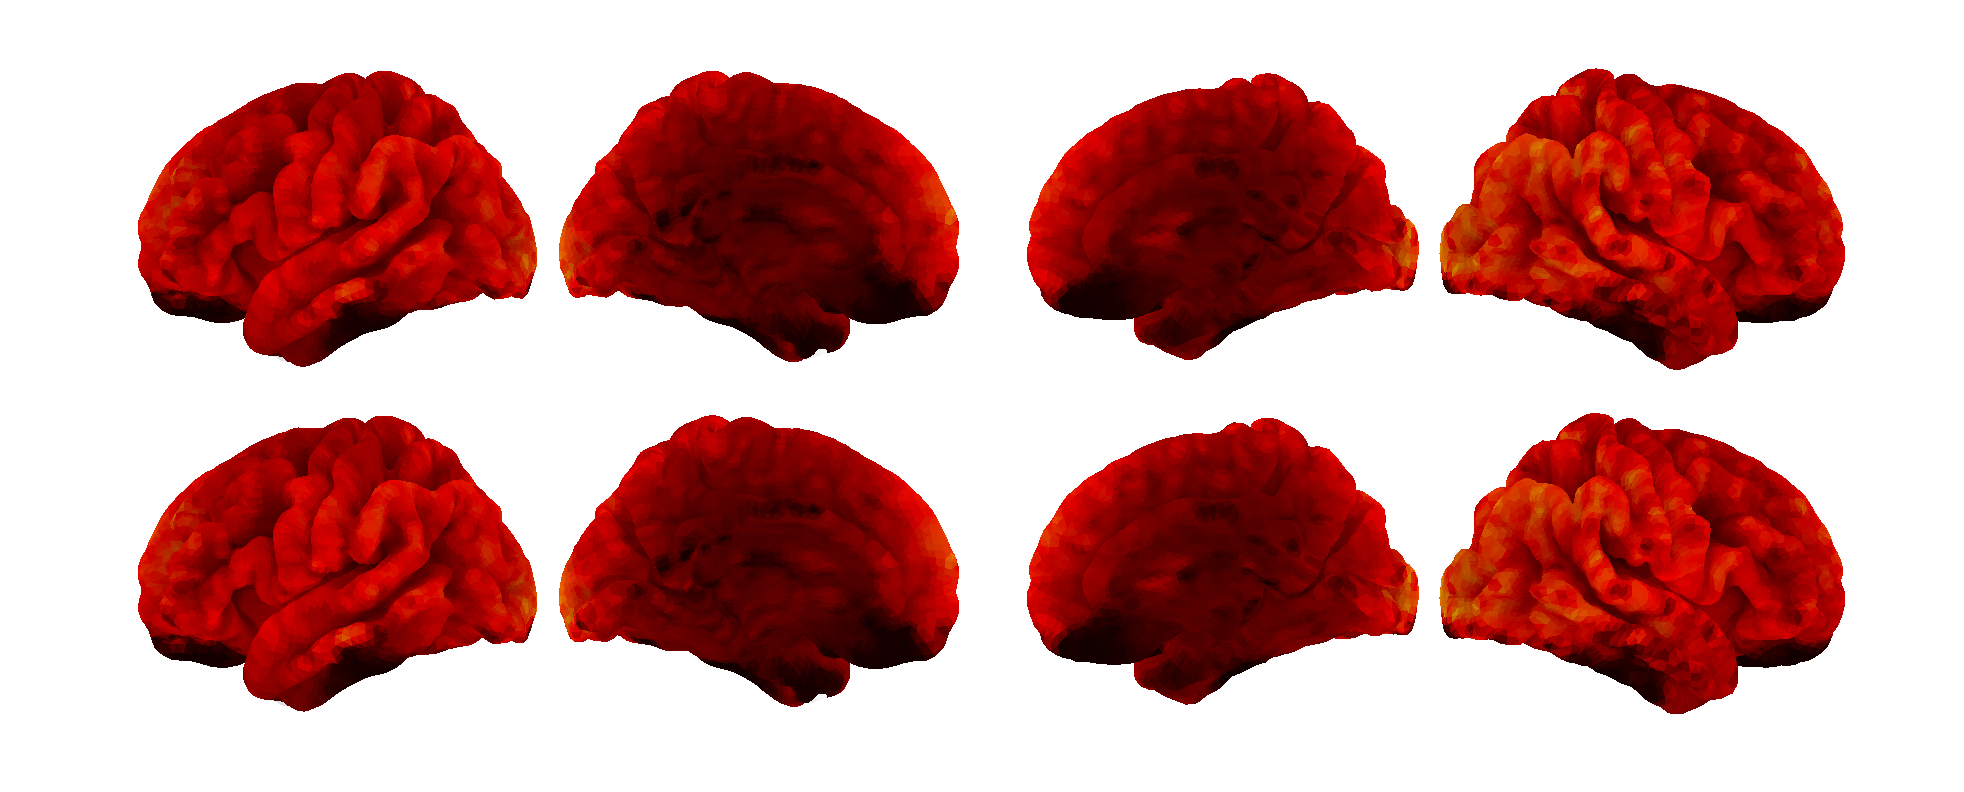

In [7]:
import numpy as np
import nibabel as nib
from nilearn import image
from src.plotting import pretty_plot

imgs = [image.index_img(nib.load(fmri_data[0]), 5), image.index_img(nib.load(fmri_data[0]), 100)]
vmax = np.max(imgs[0].get_fdata())

pretty_plot(
    imgs, 
    zmaps=None, 
    masks=None,
    names=['img-5', 'img-100'],
    ref_img=None,
    vmax=vmax, 
    cmap='cold_hot',
    saving_folder='../derivatives/', 
    plot_name='First_Image',
    row_size_factor=6,
    overlapping=6,
    column_size_factor=8,
    )

This data is volumic and include many point outside brain volume. You want to filter them out.

To do so you use a NiftiMasker object that transforms your NifitImage into a numpy array, keeping only voxels of interest (where there is enough signal).

In [2]:
from src.data import load_fmri_data, load_stmuli, fetch_masker, preprocess_fmri_data, preprocess_stimuli_data

# Fetch or create a masker object that retrieve the voxels of interest in the brain
masker = fetch_masker('./derivatives/masker', fmri_data, **{'detrend': True, 'standardize': True})

# Process fmri data with the masker
fmri_data = preprocess_fmri_data(fmri_data, masker)
stimuli_data = preprocess_stimuli_data(stimuli_data)

In [3]:
import nibabel as nib
import pandas as pd

print(f'There are {len(fmri_data)} files of fMRI data.')
print(f'Of sizes: {[i.shape for i in fmri_data]}')

print(f'There are {len(stimuli_data)} files of stimuli data.')
print(stimuli_data[0].head())

There are 5 files of fMRI data.
Of sizes: [(493, 27761), (450, 27761), (450, 27761), (444, 27761), (444, 27761)]
There are 5 files of stimuli data.
    Onset  Offset       Word
0  0.0125  1.5425  everybody
1  1.5425  1.6925        shh
2  1.6925  2.3225        shh
3  2.3525  3.4025    central
4  3.4025  3.8325       perk


In [4]:
import numpy as np
from src.utils import get_groups

# Compute the number of rows in each run (= the number of samples extracted from the model for each run)
gentles = [s['Offset'].values for s in stimuli_data]
groups = get_groups(gentles)

# Preparing fMRI data
nscans = [f.shape[0] for f in fmri_data] # number of scnas per session
Y = np.vstack(fmri_data)
Y.shape

(2281, 27761)

## Extracting Features

### GloVe

In [5]:
import os, gdown

# Loading GloVe Model
trained_model = './data/glove.6B.300d.txt'
if not os.path.exists(trained_model):
    url = "https://nlp.stanford.edu/data/glove.6B.zip"
    output = './data/glove.zip'
    gdown.download(url, output, quiet=False)
    os.system(f'unzip {output} -d ./data/')


In [6]:
import pandas as pd
from tqdm import tqdm
from src.models import extract_glove_features

# Create the GloVe model which is a dictionary from the loaded file
glove_model = {}
with open(trained_model, 'r', encoding="utf-8") as f: 
    for line in tqdm(f): 
        values = line.split() 
        word = values[0] 
        vector = np.asarray(values[1:], "float32") 
        glove_model[word] = vector 

print(f"The vector associated with ‘the‘ has the size: {glove_model['the'].size}")


glove_model = extract_glove_features.update_model(glove_model, embedding_size=300)

features_glove = []
FEATURE_COUNT = 300 # glove representation are vectors of size 300
for s in stimuli_data:
    words = s['Word'].values
    features = []
    columns = ['embedding-{}'.format(i) for i in range(1, 1 + FEATURE_COUNT)]
    features = []
    for item in tqdm(words):
        if item not in glove_model.keys():
            print(item)
            item = '<unk>'
        features.append(glove_model[item])
    features = pd.DataFrame(np.vstack(features), columns=columns)
    features_glove.append(features)
print(features_glove[0].head())

400000it [00:21, 18621.23it/s]


The vector associated with ‘the‘ has the size: 300


100%|██████████| 1333/1333 [00:00<00:00, 1615898.04it/s]


   embedding-1  embedding-2  embedding-3  embedding-4  embedding-5  \
0     0.028774     0.091027      0.23404      0.10720    -0.067256   
1     1.125000    -0.476420      0.53420      0.44380    -0.262860   
2     1.125000    -0.476420      0.53420      0.44380    -0.262860   
3    -0.082372    -0.203110     -0.37970     -0.64093     0.315040   
4     0.234350     0.016208     -0.20724      0.14880     0.473860   

   embedding-6  embedding-7  embedding-8  embedding-9  embedding-10  ...  \
0     0.251000    -0.014845     0.065653      0.13384      -1.26780  ...   
1     0.908110    -0.349840    -0.439340     -0.11631      -0.29070  ...   
2     0.908110    -0.349840    -0.439340     -0.11631      -0.29070  ...   
3    -0.060771     0.082182     0.726650     -0.27680      -1.71890  ...   
4     0.155480     0.519830     0.261240     -0.09427       0.29063  ...   

   embedding-291  embedding-292  embedding-293  embedding-294  embedding-295  \
0        0.31578       -0.11004      -0.08

In [7]:
## --> Do the entire stuff quickly <--
## Load the GloVe model
#from models import extract_glove_features
#gpt2_model, tokenizer = extract_glove_features.load_glove_model()
#
## Extracting features with GloVe
#features_glove = [
#    extract_glove_features.extract_features(
#        s['word'].values, 
#        glove_model, 
#        FEATURE_COUNT=768,
#        ) for s in stimuli_data
#    ] # list of pandas DataFrames
#

In [8]:
features_glove = [df.values for df in features_glove]
X_glove = np.vstack(features_glove) # shape: (#words_total * #features)
print(X_glove.shape)

(5981, 300)


### GPT-2

In [9]:
from src.models import extract_gpt2_features

# Loading GPT-2 Model
gpt2_model, tokenizer = extract_gpt2_features.load_model_and_tokenizer('gpt2')

In [10]:

words = stimuli_data[0]['Word'].values
sample_words = words[:100]
iterator = ' '.join(sample_words)

print('Example of stimuli sample given to the model:')
print(' '.join(sample_words))

tokenized_text = tokenizer.tokenize(iterator)
print(f'Tokenized text: {tokenized_text}')
mapping = extract_gpt2_features.match_tokenized_to_untokenized(tokenized_text, iterator)
print(f'We learn how a given word is separated into several tokens: {mapping}')


Example of stimuli sample given to the model:
everybody shh shh central perk is proud to present the music of miss phoebe buffay hi i want to start with a song that's about that moment when you suddenly realize what life is really all about okay here we go okay thank you very much what the oh great this is just wow this is so cool the entire city is blacked out mom says it's all of manhattan parts of brooklyn and queens and they have no idea when it's coming back on guys this is big pants and a sweater why mom who am i going to
Tokenized text: ['every', 'body', 'Ġsh', 'h', 'Ġsh', 'h', 'Ġcentral', 'Ġperk', 'Ġis', 'Ġproud', 'Ġto', 'Ġpresent', 'Ġthe', 'Ġmusic', 'Ġof', 'Ġmiss', 'Ġph', 'oe', 'be', 'Ġbuff', 'ay', 'Ġhi', 'Ġi', 'Ġwant', 'Ġto', 'Ġstart', 'Ġwith', 'Ġa', 'Ġsong', 'Ġthat', "'s", 'Ġabout', 'Ġthat', 'Ġmoment', 'Ġwhen', 'Ġyou', 'Ġsuddenly', 'Ġrealize', 'Ġwhat', 'Ġlife', 'Ġis', 'Ġreally', 'Ġall', 'Ġabout', 'Ġokay', 'Ġhere', 'Ġwe', 'Ġgo', 'Ġokay', 'Ġthank', 'Ġyou', 'Ġvery', 'Ġmuch', 'Ġ

In [11]:
context_size = 50    # number of tokens before each token for which we retrieve the embedding vector
max_seq_length = 512  # maximum input size that can be given to the model
space='Ġ'             # specific to the tokenizer...
special_token_beg='<|endoftext|>' # special tokens added at the beginning of the sentence specific to the tokenizer...
special_token_end='<|endoftext|>' # special tokens added at the end of the sentence specific to the tokenizer...


input_ids, indexes, tokens = extract_gpt2_features.batchify_to_truncated_input(
    iterator, tokenizer, 
    context_size=context_size, 
    max_seq_length=max_seq_length, 
    space=space, 
    special_token_beg=special_token_beg, 
    special_token_end=special_token_end)

print(input_ids)
print(input_ids.shape)
print()
print(indexes)

tensor([[50256, 16833,  2618,  ...,   845,   220, 50256],
        [50256,  2618,   427,  ...,   881,   220, 50256],
        [50256,   427,    71,  ...,   644,   220, 50256],
        ...,
        [50256, 28796,   428,  ...,  1016,   220, 50256],
        [50256,   428,   318,  ...,   284,   220, 50256],
        [50256,   318,   523,  ...,   220, 50256,   220]])
torch.Size([63, 55])

[(1, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 5

In [12]:
# Extracting features with GPT-2
features_gpt2 = [
    extract_gpt2_features.extract_features(
        s['Word'].values, 
        gpt2_model, 
        tokenizer,
        bsz=32, # reduce bsz to 16 (or even to 8) if you have memory issue
        FEATURE_COUNT=768,
        NUM_HIDDEN_LAYERS=12,
        ) for s in stimuli_data
    ] # list of pandas DataFrames

features_gpt2 = [df.values for df in features_gpt2]
X_gpt2 = np.vstack(features_gpt2) # shape: (#words_total * #features)
print(X_gpt2.shape)


Token indices sequence length is longer than the specified maximum sequence length for this model (1352 > 1024). Running this sequence through the model will result in indexing errors
  0%|          | 0/43 [00:00<?, ?it/s]

### Training the encoding model

In [ ]:
from src.encoder import Encoder

fmri_ndim = None
features_ndim = 50
features_reduction_method = 'pca'
fmri_reduction_method = None
tr = 1.49
encoding_method = 'hrf'
linearmodel = 'ridgecv'

encoder = Encoder(
    linearmodel=linearmodel, 
    features_reduction_method=features_reduction_method, 
    fmri_reduction_method=fmri_reduction_method, 
    fmri_ndim=fmri_ndim, 
    features_ndim=features_ndim, 
    encoding_method=encoding_method, 
    tr=tr
    )


**Pearson Correlation (PC)** is computed as 
$$\frac{1}{N}\sum_{i=1}^{n} corr[Y_i, \hat{Y}_i]$$

where corr is the correlation function.

In [ ]:
encoder.fit(X_glove, Y, groups=groups, gentles=gentles, nscans=nscans)
pred = encoder.predict(X_glove)
scores_glove = encoder.eval(pred, Y)



NameError: name 'X_glove' is not defined

In [ ]:
encoder.fit(X_gpt2, Y, groups=groups, gentles=gentles, nscans=nscans)
pred = encoder.predict(X_gpt2)
scores_gpt2 = encoder.eval(pred, Y)

NameError: name 'X_gpt2' is not defined

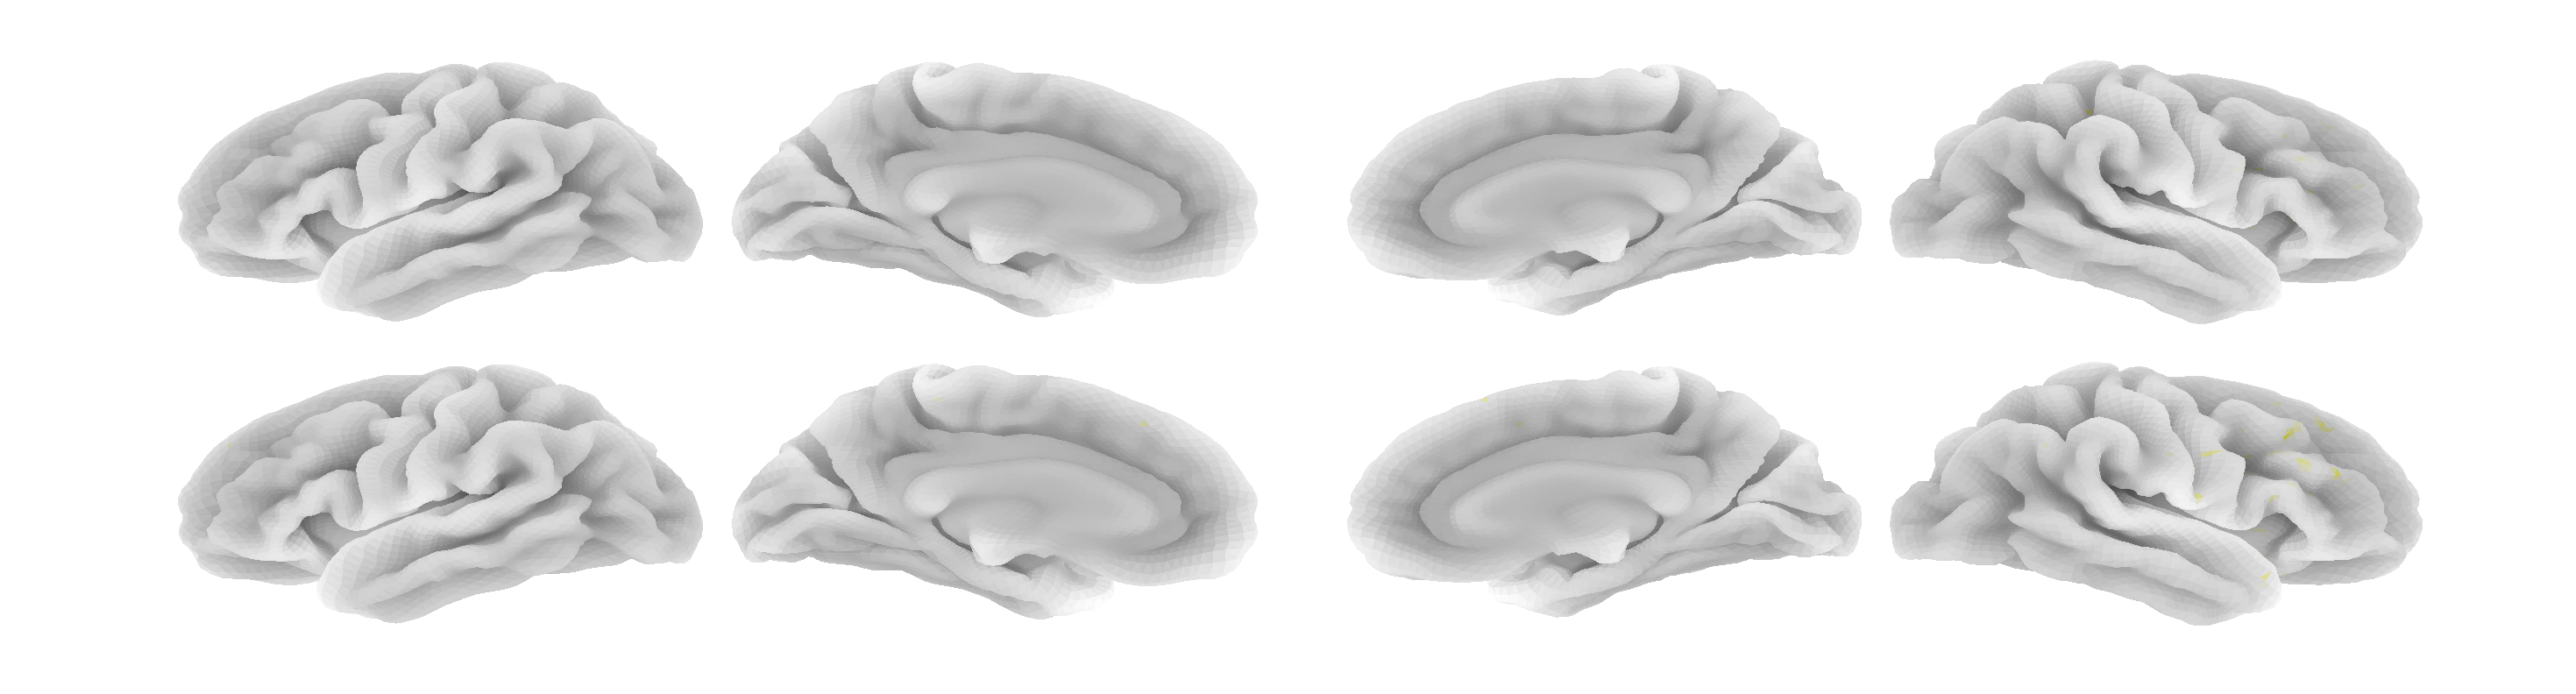

In [ ]:

imgs = [masker.inverse_transform(scores_glove), masker.inverse_transform(scores_gpt2)]
zmaps = None
masks = None
names = ['GloVe', 'GPT-2']

pretty_plot(
    imgs, 
    zmaps, 
    masks,
    names,
    ref_img=None,
    vmax=0.5, 
    cmap='cold_hot',
    hemispheres=['left', 'right'], 
    views=['lateral', 'medial'], 
    categorical_values=None, 
    inflated=False, 
    saving_folder='../derivatives/', 
    format_figure='pdf', 
    dpi=300, 
    plot_name='test',
    row_size_factor=6,
    overlapping=6,
    column_size_factor=12,
    )


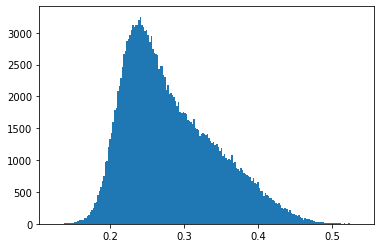

In [ ]:
import matplotlib.pyplot as plt
plt.hist(scores_glove, bins=200)
plt.show()

## Using (precomputed) Visual, Auditory and Linguistic features

In [ ]:
!git clone https://github.com/jashna14/DL4Brain.git
!tar -xvzf DL4Brain/data/features.zip

**ATTENTION!!!**
To gain access to the fMRI data, please fill out this [short form](https://docs.google.com/forms/d/e/1FAIpQLSeC68uQA5sBxowTA-vYU8V-MOaKP1QRBOU_EJxGm3lIi4Te-A/viewform?usp=share_link) and follow the instructions in the end. 

In [ ]:
import gdown
url = 'https://tinyurl.com/yc7v2dx8'
output = '.data/fmri_toneva.zip'
gdown.download(url, output, quiet=False)

In [ ]:
!unzip fmri.zip

In [ ]:
import json
import os
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
import pandas as pd
from DL4Brain.src.ridge import bootstrap_ridge
from DL4Brain.src.evaluate import *
import scipy.stats as stats
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
# from Feature_extraction import *

import warnings
warnings.filterwarnings("ignore")

We will be using the "figures" movie data from the movie-10 dataset. This figures dataset includes about 120 minutes of functional data for all 6 participants. This movie was presented twice, but we'll go with first run of the movie. We will be working with one subject for the time being.

We will be extracting Visual and Audio features from the the stimuli i.e video clips. 
Each of the 12 clips were broken down into 1.49 second smaller clips and for each of them, we extract visual, textual and audio features.

We extract **Visual features** using a pre-trained ResNet-50 model, using the gluon-cv toolkit. It return a 2048 dimension vector for each smaller clip. To read more about the gluoncv library, checkout their github repository at [here](https://github.com/dmlc/gluon-cv)

We extracted the **MFCC features** from the Audio extracted from the smaller clips. It returns 20 dimension vector for each smaller clip. To read more about MFCC or librosa (python library used to extract MFCC features), you can refer to [link1](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), [link2](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html) 

For **Textual fetures**, we extracted them using the pre-trained BERT model from Hugging Face. It returns 768 dimension vector for each smaller clip. For each smaller clip we pass the words spoken in it together as an input to the BERT and take the CLS embedding as a represntation for those words. You can read more about it at [here](https://huggingface.co/docs/transformers/model_doc/bert) 

In [ ]:
train_session = {'007': ['01','02','03']}
test_session = {'009': ['04']}

fmri_original_train = []
fmri_original_test = []

Load fMRI data:

In [ ]:
for ses in list(train_session.keys()):
    for clip in train_session[ses]:
        fmri_filepath = 'fmri/sub-01_ses-'+ses+'_task-figures'+clip+'_run-1_space-fsLR_den-91k_bold.dtseries.nii'
        img = nib.load(fmri_filepath)
        fmri_original_train.append(img.get_data())
        
for ses in list(test_session.keys()):
    for clip in test_session[ses]:
        fmri_filepath = 'fmri/sub-01_ses-'+ses+'_task-figures'+clip+'_run-1_space-fsLR_den-91k_bold.dtseries.nii'
        img = nib.load(fmri_filepath)
        fmri_original_test.append(img.get_data())
    

## Load stimuli and extract features

We will be extracting Visual and Audio features from the the stimuli i.e video clips. 
Each of the 12 clips were broken down into 1.49 second smaller clips and for each of them, we extract visual and audio features. We can use librosa library to extract MFCC features for the audio.

In [ ]:
video_feats_train = []
audio_feats_train = []
text_feats_train = []

video_feats_test = []
audio_feats_test = []
text_feats_test = []

## Extracting audio,text and video features from stimuli

# for ses in list(train_session.keys()):
#     for clip in train_session[ses]:
#         clip_filepath = '../../../Desktop/movie10.stimuli/figures/figures'+clip+'.mkv'
#         tr_time = json.load(open('../../../Desktop/movie10.fmriprep/sourcedata/movie10/task-figures'+clip+'_bold.json'))['RepetitionTime']
#         clip_video_feats, clip_audio_feats, clip_text_feats = extract_stimuli_features(clip_filepath,tr_time)
        
#         video_feats_train.append(clip_video_feats)
#         audio_feats_train.append(clip_audio_feats)
#         text_feats_train.append(clip_text_feats)
        
# for ses in list(test_session.keys()):test_session = {'009': ['04','10','11','12']}
#     for clip in test_session[ses]:
#         clip_filepath = '../../../Desktop/movie10.stimuli/figures/figures'+clip+'.mkv'
#         tr_time = json.load(open('../../../Desktop/movie10.fmriprep/sourcedata/movie10/task-figures'+clip+'_bold.json'))['RepetitionTime']
#         clip_video_feats, clip_audio_feats, clip_text_feats = extract_stimuli_features(clip_filepath,tr_time)
        
#         video_feats_test.append(clip_video_feats)
#         audio_feats_test.append(clip_audio_feats)
#         text_feats_test.append(clip_text_feats)



## Loading pre-extracted features
for ses in list(train_session.keys()):
    for clip in train_session[ses]:
        video_feats_filepath = './data/figures'+clip+'_video.npy'
        audio_feats_filepath = './data/figures'+clip+'_audio.npy'
        text_feats_filepath = './data/figures'+clip+'_text.npy'
        
        if clip == '03':
          video_feats_train.append(np.load(video_feats_filepath)[:-1, :])
          audio_feats_train.append(np.load(audio_feats_filepath)[:-1, :])
        else:
          video_feats_train.append(np.load(video_feats_filepath))
          audio_feats_train.append(np.load(audio_feats_filepath))
        text_feats_train.append(np.load(text_feats_filepath,allow_pickle=True))
        
for ses in list(test_session.keys()):
    for clip in test_session[ses]:
        video_feats_filepath = './data/figures'+clip+'_video.npy'
        audio_feats_filepath = './data/figures'+clip+'_audio.npy'
        text_feats_filepath = './data/figures'+clip+'_text.npy'
                
        video_feats_test.append(np.load(video_feats_filepath))
        audio_feats_test.append(np.load(audio_feats_filepath))
        text_feats_test.append(np.load(text_feats_filepath, allow_pickle=True))

There is generally a delay in neural activity peaking and the stimuli onset. Thus to account for this delay, we train our model to predict $y_{i}$ (Fmri) using concat($x_{i-6},x_{i-5},x_{i-4},x_{i-3},x_{i-2},x_{i-1}$) (stimuli features) 

In [ ]:
k = 6

final_fmri_train = []
final_audio_feats_train = []
final_video_feats_train = []
final_fmri_test = []
final_audio_feats_test = []
final_video_feats_test = []


for i in range(len(audio_feats_train)):
    for j in range(0,audio_feats_train[i].shape[0]-k):
        final_audio_feats_train.append(np.concatenate(audio_feats_train[i][j:j+k]))
        final_video_feats_train.append(np.concatenate(video_feats_train[i][j:j+k]))
        final_fmri_train.append(fmri_original_train[i][j+k])
    
for i in range(len(audio_feats_test)):
    for j in range(0,audio_feats_test[i].shape[0]-k):
        final_audio_feats_test.append(np.concatenate(audio_feats_test[i][j:j+k]))
        final_video_feats_test.append(np.concatenate(video_feats_test[i][j:j+k]))
        final_fmri_test.append(fmri_original_test[i][j+k])
        

## Normalising the Features and Fmri
final_fmri_train = stats.zscore(np.array(final_fmri_train))
final_audio_feats_train = stats.zscore(np.array(final_audio_feats_train))
final_video_feats_train = stats.zscore(np.array(final_video_feats_train))
final_fmri_test = stats.zscore(np.array(final_fmri_test))
final_audio_feats_test = stats.zscore(np.array(final_audio_feats_test))
final_video_feats_test = stats.zscore(np.array(final_video_feats_test))

In [ ]:
final_fmri_train = np.nan_to_num(final_fmri_train) # convert nan values to zero
final_fmri_test = np.nan_to_num(final_fmri_test) # convert nan values to zero

In [ ]:
# Deleting non-required (inbetween) variables
del video_feats_train
del audio_feats_train
del video_feats_test
del audio_feats_test

In [ ]:
fmri_text_train = []
fmri_text_test = []
inter_text_feats_train = []
inter_text_feats_test = []

for i in range(len(text_feats_train)):
    i_fmri = fmri_original_train[i]
    i_feats = text_feats_train[i]
    
    i_fmri = i_fmri[0:i_feats.shape[0]]
    
    empty_indices = [k for k in range(0,len(i_feats)) if len(i_feats[k]) == 0]
    i_fmri = np.delete(i_fmri, empty_indices, axis=0)
    i_feats = np.delete(i_feats, empty_indices, axis=0)
    
    fmri_text_train.append(i_fmri)
    inter_text_feats_train.append(i_feats)
    
for i in range(len(text_feats_test)):
    i_fmri = fmri_original_test[i]
    i_feats = text_feats_test[i]
    
    i_fmri = i_fmri[0:i_feats.shape[0]]
    
    empty_indices = [k for k in range(0,len(i_feats)) if len(i_feats[k]) == 0]
    i_fmri = np.delete(i_fmri, empty_indices, axis=0)
    i_feats = np.delete(i_feats, empty_indices, axis=0)
    
    fmri_text_test.append(i_fmri)
    inter_text_feats_test.append(i_feats)

In [ ]:
# Deleting non-required variables
del fmri_original_train
del fmri_original_test
del text_feats_train
del text_feats_test

In [ ]:
k = 6

final_fmri_text_train = []
final_text_feats_train = []
final_fmri_text_test = []
final_text_feats_test = []

for i in range(len(inter_text_feats_train)):
    for j in range(0,inter_text_feats_train[i].shape[0]-k):
        final_text_feats_train.append(np.concatenate(inter_text_feats_train[i][j:j+k]))
        final_fmri_text_train.append(fmri_text_train[i][j+k])
    
for i in range(len(inter_text_feats_test)):
    for j in range(0,inter_text_feats_test[i].shape[0]-k):
        final_text_feats_test.append(np.concatenate(inter_text_feats_test[i][j:j+k]))
        final_fmri_text_test.append(fmri_text_test[i][j+k])
        

## Normalising the Features and Fmri
final_fmri_text_train = stats.zscore(np.array(final_fmri_text_train))
final_fmri_text_test = stats.zscore(np.array(final_fmri_text_test))
final_text_feats_train = stats.zscore(np.array(final_text_feats_train))
final_text_feats_test = stats.zscore(np.array(final_text_feats_test))

In [ ]:
final_fmri_text_train = np.nan_to_num(final_fmri_text_train)
final_fmri_text_test = np.nan_to_num(final_fmri_text_test)

In [ ]:
# Deleting non-required variables
del inter_text_feats_train
del inter_text_feats_test
del fmri_text_train
del fmri_text_test

To do cross-validation, bootstrap_ridge divides the Regression dataset into many small chunks, and then splits those chunks into the two groups that will be used to estimate weights and test  𝛼  values. This is better than just choosing individual time points because both the fMRI data and stimuli are autocorrelated (i.e. correlated across time). The parameter chunklen determines the length of the chunks, and the parameter nchunks determines the number of chunks in the  𝛼 -testing dataset.

In [ ]:
def run_ridge(X_train, y_train, X_test, y_test):
  alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
  nboots = 1 # Number of cross-validation runs.
  chunklen = 40 # 
  nchunks = 20

  wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(X_train, y_train, X_test, y_test,
                                                      alphas, nboots, chunklen, nchunks,
                                                      singcutoff=1e-10, single_alpha=True)
  y_pred = np.matmul(X_test,wt)
  actual = y_test
  predicted = y_pred
  predicted = stats.zscore(predicted)
  predicted = np.nan_to_num(predicted)
  return actual, predicted

## For visual features

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1024)
final_video_feats_train = pca.fit_transform(final_video_feats_train)
final_video_feats_test = pca.transform(final_video_feats_test)

X_train = final_video_feats_train
X_test = final_video_feats_test
y_train = final_fmri_train
y_test = final_fmri_test

actual_video, predicted_video = run_ridge(X_train, y_train, X_test, y_test) 

acc = acc_2v2(actual_video, predicted_video)
p_corr = corr_pearson(actual_video, predicted_video)

print("2v2 Accuracy for Video(visual) features is",round(acc,2))
print("Pearson correlation for Video(visual) features is",round(p_corr,2))

## For audio features

In [ ]:
X_train = final_audio_feats_train
X_test = final_audio_feats_test
y_train = final_fmri_train
y_test = final_fmri_test

actual_audio, predicted_audio = run_ridge(X_train, y_train, X_test, y_test) 

acc = acc_2v2(actual_audio, predicted_audio)
p_corr = corr_pearson(actual_audio, predicted_audio)

print("2v2 Accuracy for Audio features is",round(acc,2))
print("Pearson correlation for Audio features is",round(p_corr,2))

## For textual features

In [ ]:
X_train = final_text_feats_train
X_test = final_text_feats_test
y_train = final_fmri_text_train
y_test = final_fmri_text_test

actual_textual, predicted_textual = run_ridge(X_train, y_train, X_test, y_test) 

acc = acc_2v2(actual_textual, predicted_textual)
p_corr = corr_pearson(actual_textual, predicted_textual)

print("2v2 Accuracy for Textual features is",round(acc,2))
print("Pearson correlation for Textual features is",round(p_corr,2))